In [ ]:
# Imports, Load Data & Basic Info


In [68]:
# Import all necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set working directory to project root
os.chdir(r"D:\10 acadamy\solar-challenge-week1")
print("Current working directory:", os.getcwd())

# Load the data
df = pd.read_csv("data/benin_raw.csv", low_memory=False)
print("✅ Data loaded successfully!")
print(f"Dataset shape: {df.shape}")

Current working directory: D:\10 acadamy\solar-challenge-week1
✅ Data loaded successfully!
Dataset shape: (1000, 14)


In [ ]:
#Summary Statistics & Missing Values


In [ ]:
# =============================================================================
# 1. SUMMARY STATISTICS & MISSING-VALUE REPORT
# =============================================================================
print("="*60)
print("📊 SUMMARY STATISTICS & MISSING-VALUE REPORT")
print("="*60)

# Summary statistics - show all columns
print("\n1. SUMMARY STATISTICS (all numeric columns):")
with pd.option_context('display.max_columns', None, 'display.width', 1000):
    print(df.describe())

# Missing value analysis - show all columns
print("\n2. MISSING VALUE ANALYSIS:")
missing_data = df.isna().sum()
missing_percent = (missing_data / len(df)) * 100

missing_report = pd.DataFrame({
    'Missing_Count': missing_data,
    'Missing_Percent': missing_percent.round(2)
})

# Display all columns without truncation
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 1000):
    print(missing_report)

# Columns with >5% nulls
high_missing_cols = missing_percent[missing_percent > 5].index.tolist()
print(f"\n3. COLUMNS WITH >5% MISSING VALUES ({len(high_missing_cols)} columns):")
for col in high_missing_cols:
    print(f"   - {col}: {missing_percent[col]:.2f}% missing")

🔍 DATA VALIDATION CHECK
DataFrame shape: (1000, 14)
Number of rows: 1000
Number of columns: 14

📊 COLUMN TYPES:
Timestamp                      object
Latitude                      float64
Longitude                     float64
GHI (W/m²)                    float64
DNI (W/m²)                    float64
DHI (W/m²)                    float64
Temp (°C)                     float64
RH (%)                        float64
Pressure (hPa)                float64
Dew Point (°C)                float64
Wind Speed (m/s)              float64
Cloud Type                     object
Solar Zenith Angle (°)        float64
Target_GHI_NextHour (W/m²)    float64
dtype: object

🔢 NUMERIC COLUMNS: 12
['Latitude', 'Longitude', 'GHI (W/m²)', 'DNI (W/m²)', 'DHI (W/m²)', 'Temp (°C)', 'RH (%)', 'Pressure (hPa)', 'Dew Point (°C)', 'Wind Speed (m/s)', 'Solar Zenith Angle (°)', 'Target_GHI_NextHour (W/m²)']

📊 SUMMARY STATISTICS & MISSING-VALUE REPORT

1. SUMMARY STATISTICS:
          Latitude    Longitude   GHI (W/m²)   

In [ ]:
#Rename Columns


In [69]:
# =============================================================================
# 2. RENAME COLUMNS TO STANDARD NAMES
# =============================================================================
print("\n" + "="*60)
print("🔄 RENAMING COLUMNS TO STANDARD NAMES")
print("="*60)

# Rename columns
df = df.rename(columns={
    'Global_Horizontal_Irradiance': 'GHI',
    'Direct_Normal_Irradiance': 'DNI',
    'Diffuse_Horizontal_Irradiance': 'DHI',
    'Temperature': 'Tamb',
    'GHI (W/m²)': 'GHI',
    'DNI (W/m²)': 'DNI',
    'DHI (W/m²)': 'DHI',
    'Temp (°C)': 'Tamb',
    'RH (%)': 'RH',
    'Pressure (hPa)': 'BP',
    'Wind Speed (m/s)': 'WS',
    'Wind Direction (deg)': 'WD'
})
print("✅ Columns renamed successfully!")
print("Current columns:", df.columns.tolist())


🔄 RENAMING COLUMNS TO STANDARD NAMES
✅ Columns renamed successfully!
Current columns: ['Timestamp', 'Latitude', 'Longitude', 'GHI', 'DNI', 'DHI', 'Tamb', 'RH', 'BP', 'Dew Point (°C)', 'WS', 'Cloud Type', 'Solar Zenith Angle (°)', 'Target_GHI_NextHour (W/m²)']


In [ ]:
#Data Cleaning (Renaming & Outliers)


In [70]:
# =============================================================================
# 3. OUTLIER DETECTION USING Z-SCORES
# =============================================================================
print("\n" + "="*60)
print("🔍 OUTLIER DETECTION (Z-score > 3)")
print("="*60)

# Columns to check for outliers
cols_to_check = ['GHI', 'DNI', 'DHI', 'Tamb', 'WS', 'RH']
cols_to_check = [c for c in cols_to_check if c in df.columns]

print("Checking outliers in:", cols_to_check)

# Initialize outlier flags
outlier_flags = pd.Series([False] * len(df))

for col in cols_to_check:
    if col in df.columns:
        # Calculate Z-scores (ignore NaN values)
        z_scores = np.abs(stats.zscore(df[col].dropna()))
        # Find outliers
        col_outliers = z_scores > 3
        print(f"   {col}: {col_outliers.sum()} outliers found")
        
        # Map outliers back to original dataframe
        valid_indices = df[col].dropna().index
        outlier_series = pd.Series(False, index=df.index)
        outlier_series.loc[valid_indices] = col_outliers
        outlier_flags = outlier_flags | outlier_series

df['outlier_flag'] = outlier_flags
print(f"📊 TOTAL ROWS WITH OUTLIERS: {outlier_flags.sum()}")


🔍 OUTLIER DETECTION (Z-score > 3)
Checking outliers in: ['GHI', 'DNI', 'DHI', 'Tamb', 'WS', 'RH']
   GHI: 2 outliers found
   DNI: 1 outliers found
   DHI: 1 outliers found
   Tamb: 3 outliers found
   WS: 4 outliers found
   RH: 0 outliers found
📊 TOTAL ROWS WITH OUTLIERS: 11


In [ ]:
#Handle Missing Values & Save Clean Data


In [71]:
# =============================================================================
# 4. HANDLE MISSING VALUES (IMPUTATION)
# =============================================================================
print("\n" + "="*60)
print("🔄 HANDLING MISSING VALUES (Median Imputation)")
print("="*60)

# Key columns for imputation
key_columns = ['GHI', 'DNI', 'DHI', 'Tamb', 'WS', 'RH']
key_columns = [c for c in key_columns if c in df.columns]

for col in key_columns:
    if col in df.columns:
        missing_before = df[col].isna().sum()
        if missing_before > 0:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            missing_after = df[col].isna().sum()
            print(f"   {col}: Imputed {missing_before} missing values with median {median_val:.2f}")


🔄 HANDLING MISSING VALUES (Median Imputation)


In [ ]:
#Remove Outliers & Save Clean Data


In [72]:
# =============================================================================
# 5. REMOVE OUTLIERS AND SHOW CLEANING IMPACT
# =============================================================================
print("\n" + "="*60)
print("🧹 REMOVING OUTLIERS & CLEANING IMPACT")
print("="*60)

# Store original stats
original_rows = len(df)
original_cols = len(df.columns)

# Remove outliers
df_clean = df[~df['outlier_flag']].copy()

# Remove the outlier flag column (no longer needed)
df_clean = df_clean.drop('outlier_flag', axis=1)


# Cleaning impact report
final_rows = len(df_clean)
rows_removed = original_rows - final_rows
percent_removed = (rows_removed / original_rows) * 100

print(f"📈 CLEANING IMPACT REPORT:")
print(f"   Original dataset: {original_rows} rows, {original_cols} columns")
print(f"   Cleaned dataset:  {final_rows} rows, {len(df_clean.columns)} columns")
print(f"   Rows removed:     {rows_removed} rows ({percent_removed:.2f}%)")

# =============================================================================
# 6. SAVE CLEANED DATA
# =============================================================================
print("\n" + "="*60)
print("💾 SAVING CLEANED DATA")
print("="*60)

# Make sure data folder exists
os.makedirs("data", exist_ok=True)

# Save cleaned data
clean_path = "data/benin_clean.csv"
df_clean.to_csv(clean_path, index=False)
print(f"✅ Saved cleaned data to: {clean_path}")


🧹 REMOVING OUTLIERS & CLEANING IMPACT
📈 CLEANING IMPACT REPORT:
   Original dataset: 1000 rows, 15 columns
   Cleaned dataset:  989 rows, 14 columns
   Rows removed:     11 rows (1.10%)

💾 SAVING CLEANED DATA
✅ Saved cleaned data to: data/benin_clean.csv


In [ ]:
#Exploratory Data Analysis - Visualizations



🔍 EXPLORATORY DATA ANALYSIS - CLEANED DATA
Cleaned dataset info:
Shape: (989, 14)
Columns: ['Timestamp', 'Latitude', 'Longitude', 'GHI', 'DNI', 'DHI', 'Tamb', 'RH', 'BP', 'Dew Point (°C)', 'WS', 'Cloud Type', 'Solar Zenith Angle (°)', 'Target_GHI_NextHour (W/m²)']

First 5 rows of cleaned data:
             Timestamp   Latitude   Longitude         GHI         DNI  \
0  1998-01-01 00:30:00  39.754943 -104.928739  341.581118  380.326236   
1  1998-01-01 01:00:00  39.832204 -105.039324  177.789175  300.146084   
2  1998-01-01 01:30:00  39.880517 -104.736875  383.384506  349.160733   
3  1998-01-01 02:00:00  39.870209 -105.075542  654.211173  215.090519   
4  1998-01-01 02:30:00  39.739962 -105.010037  562.802620  807.605770   

          DHI       Tamb         RH           BP  Dew Point (°C)        WS  \
0   72.649858  11.916165  35.728528  1010.482264       10.250311  3.278999   
1  -34.446156  20.988743  98.138223  1009.356547       19.228097  3.180614   
2  136.490584  25.183423  39.9

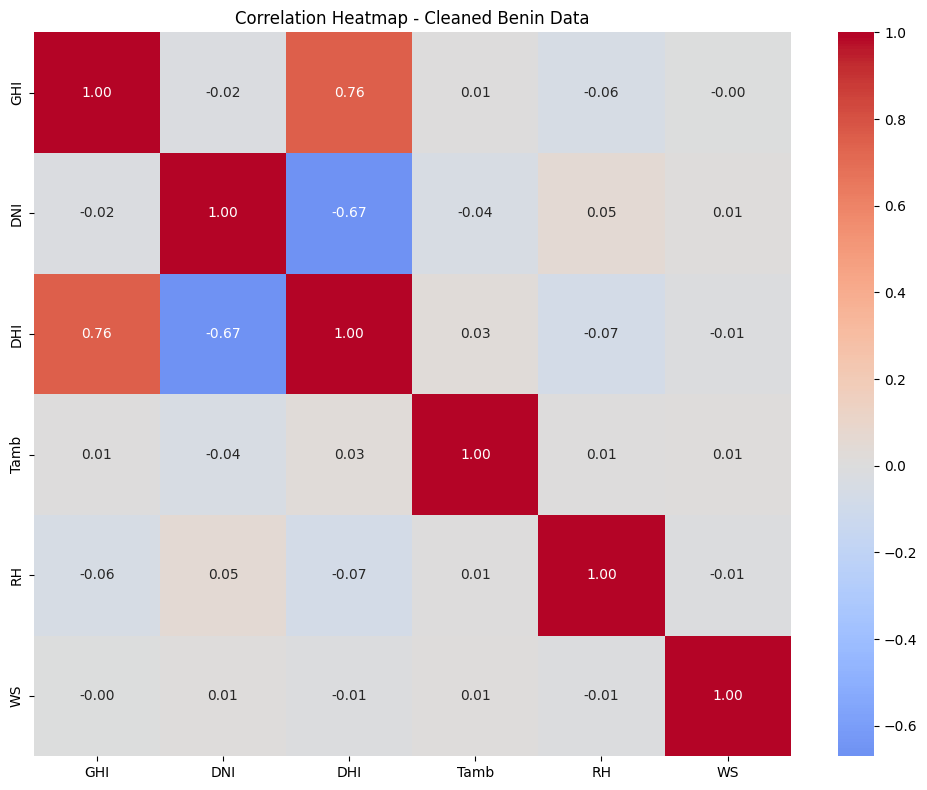

Strongest correlations with GHI:
  DHI: 0.756


In [73]:
# =============================================================================
# 7. EXPLORATORY DATA ANALYSIS (After Cleaning)
# =============================================================================
print("\n" + "="*60)
print("🔍 EXPLORATORY DATA ANALYSIS - CLEANED DATA")
print("="*60)

# Display cleaned data info
print("Cleaned dataset info:")
print(f"Shape: {df_clean.shape}")
print(f"Columns: {df_clean.columns.tolist()}")

# Check if data is not empty
if df_clean.empty:
    print("❌ WARNING: Cleaned dataframe is EMPTY! Cannot create plots.")
    print("This means all rows were removed as outliers.")
else:
    print("\nFirst 5 rows of cleaned data:")
    print(df_clean.head())

    # Correlation heatmap
    print("\n📊 CORRELATION HEATMAP:")
    corr_cols = [c for c in ['GHI', 'DNI', 'DHI', 'Tamb', 'RH', 'WS'] if c in df_clean.columns]
    
    # Check if we have at least 2 columns for correlation
    if len(corr_cols) >= 2:
        # Remove any rows with NaN values for correlation
        corr_data = df_clean[corr_cols].dropna()
        
        if not corr_data.empty:
            plt.figure(figsize=(10, 8))
            correlation_matrix = corr_data.corr()
            sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
            plt.title("Correlation Heatmap - Cleaned Benin Data")
            plt.tight_layout()
            plt.show()
            
            # Show strongest correlations with GHI
            if 'GHI' in correlation_matrix.columns:
                ghi_corrs = correlation_matrix['GHI'].sort_values(ascending=False)
                print("Strongest correlations with GHI:")
                for metric, corr in ghi_corrs.items():
                    if metric != 'GHI' and abs(corr) > 0.1:
                        print(f"  {metric}: {corr:.3f}")
        else:
            print("❌ No valid data for correlation (all NaN values)")
    else:
        print(f"❌ Not enough columns for correlation. Available: {corr_cols}")

In [ ]:
#EDA - Distribution Plots



📈 DISTRIBUTION PLOTS:


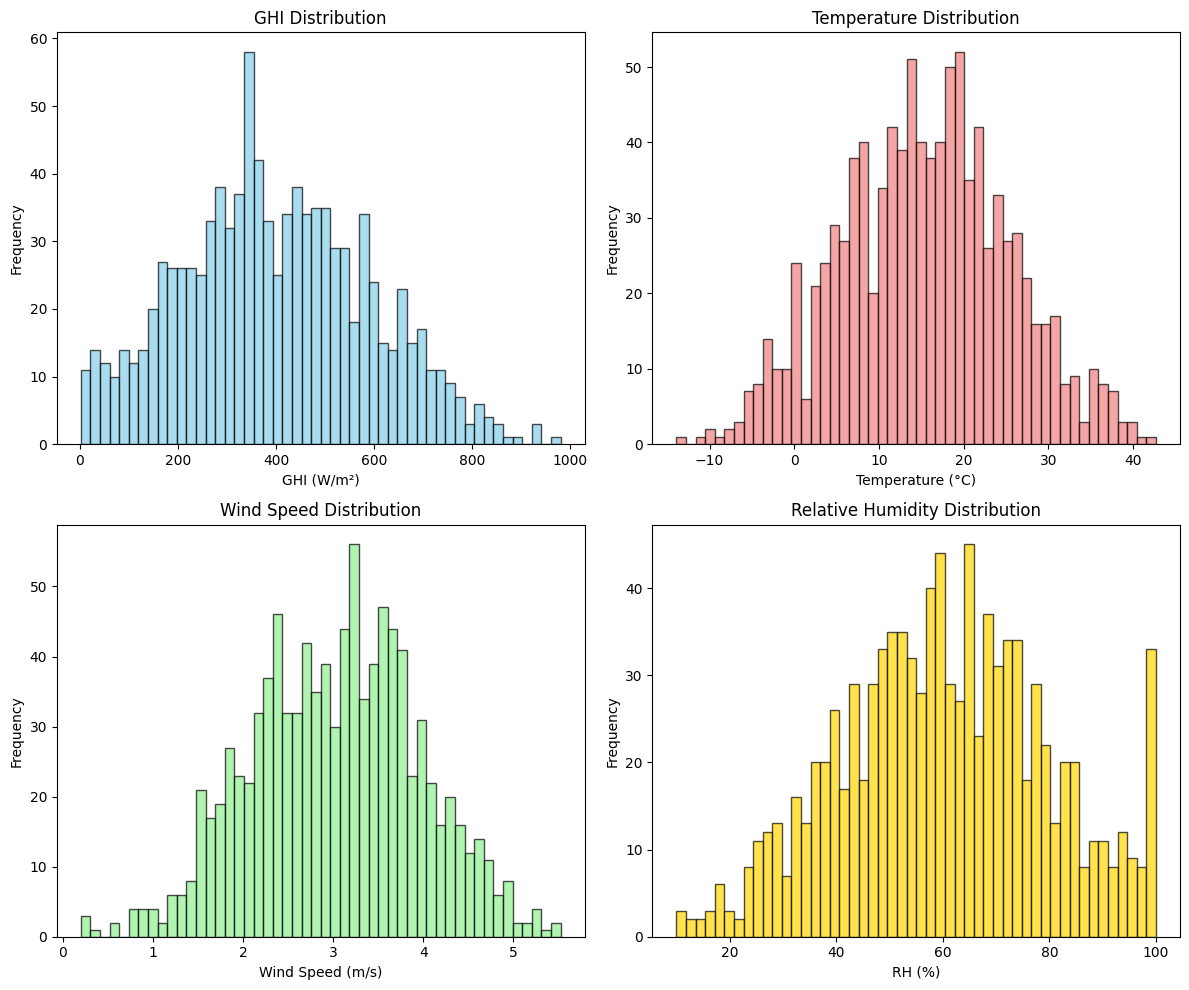

✅ BENIN DATA CLEANING & EDA COMPLETED SUCCESSFULLY!


In [74]:
# Distribution plots
print("\n📈 DISTRIBUTION PLOTS:")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# GHI Distribution
if 'GHI' in df_clean.columns:
    axes[0,0].hist(df_clean['GHI'].dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title("GHI Distribution")
    axes[0,0].set_xlabel("GHI (W/m²)")
    axes[0,0].set_ylabel("Frequency")

# Temperature Distribution  
if 'Tamb' in df_clean.columns:
    axes[0,1].hist(df_clean['Tamb'].dropna(), bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0,1].set_title("Temperature Distribution")
    axes[0,1].set_xlabel("Temperature (°C)")
    axes[0,1].set_ylabel("Frequency")

# Wind Speed Distribution
if 'WS' in df_clean.columns:
    axes[1,0].hist(df_clean['WS'].dropna(), bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1,0].set_title("Wind Speed Distribution")
    axes[1,0].set_xlabel("Wind Speed (m/s)")
    axes[1,0].set_ylabel("Frequency")

# RH Distribution
if 'RH' in df_clean.columns:
    axes[1,1].hist(df_clean['RH'].dropna(), bins=50, alpha=0.7, color='gold', edgecolor='black')
    axes[1,1].set_title("Relative Humidity Distribution")
    axes[1,1].set_xlabel("RH (%)")
    axes[1,1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

print("="*60)
print("✅ BENIN DATA CLEANING & EDA COMPLETED SUCCESSFULLY!")
print("="*60)